## Read the data first

In [50]:
from pathlib import Path

import pandas as pd

df = pd.read_csv(Path('../../results/repository_evolution_0-4924_fixed_bug_MERGED.csv'))
df_commits = pd.read_csv(Path('../../data/huggingface_sort_by_createdAt_top996939_commits_0_1035.csv'))

# grabs the date from df2 and adds it to df based on commit_hash and repo_url matching, implementation needs to be efficient
def add_date_to_df(df, df_commits):
    df['date'] = ""
    for index, row in df.iterrows():
        commit_hash = row['commit_hash']
        repo_url = row['repo_url']
        matched_row = df_commits.loc[
            (df_commits['commit_hash'] == commit_hash) & 
            (df_commits['repo_url'] == repo_url)
        ]
        
        df.at[index, 'date'] = matched_row['date'].values[0]
        df.at[index, 'message'] = matched_row['message'].values[0]
    return df

df = add_date_to_df(df, df_commits)
df['date'] = pd.to_datetime(df['date'])

# Reference date when safetensors was released
reference_date = pd.to_datetime("2022-09-23")

# Calculate elapsed days since reference date
df['elapsed_days'] = (df['date'] - reference_date).dt.days

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']

# Group by elapsed days to count files modified on each date
files_modified_by_elapsed_days = df_safetensors['elapsed_days'].value_counts().sort_index()

# Group by date and count the number of files modified on that date
files_modified_by_date = df_safetensors['date'].value_counts().sort_index()

df_safetensors

,repo_url,commit_hash,model_file_path,serialization_format,date,message,elapsed_days
3,sentence-transformers/all-MiniLM-L6-v1,4ccf77db5049cc31b815180ea2d79ff4d4a1fccd,sentence-transformers/all-MiniLM-L6-v1/model.s...,safetensors,2024-03-27 05:40:56,Adding `safetensors` variant of this model (#3...,551
5,sentence-transformers/all-MiniLM-L12-v2,a05860a77cef7b37e0048a7864658139bc18a854,sentence-transformers/all-MiniLM-L12-v2/model....,safetensors,2024-03-26 10:05:34,Adding `safetensors` variant of this model (#8...,550
7,sentence-transformers/all-MiniLM-L12-v1,0845ca5ddc07524b3196519cf3940ceb86cf106c,sentence-transformers/all-MiniLM-L12-v1/model....,safetensors,2024-03-27 05:40:13,Adding `safetensors` variant of this model (#2...,551
9,sentence-transformers/LaBSE,50fe0940fa3ca3be4d2170f21395beb6d581fc44,sentence-transformers/LaBSE/2_Dense/model.safe...,safetensors,2024-03-27 05:39:35,Adding `safetensors` variant of this model (#6...,551
10,sentence-transformers/LaBSE,50fe0940fa3ca3be4d2170f21395beb6d581fc44,sentence-transformers/LaBSE/model.safetensors,safetensors,2024-03-27 05:39:35,Adding `safetensors` variant of this model (#6...,551
...,...,...,...,...,...,...,...
7558,T-Systems-onsite/cross-en-de-roberta-sentence-...,fb7dea62734262b9155eeaf0881ae177eaa7ceaf,T-Systems-onsite/cross-en-de-roberta-sentence-...,safetensors,2023-04-27 15:29:30,Adding `safetensors` variant of this model (#4...,216
7562,albert/albert-xlarge-v1,e9b59dbe40d22eb6ec042cf6af216207665f0320,albert/albert-xlarge-v1/model.safetensors,safetensors,2023-08-11 03:30:41,Adding `safetensors` variant of this model (#1...,322
7567,albert/albert-large-v2,1e2b86a91a3c63b5707d038747fb30838d9e7bac,albert/albert-large-v2/model.safetensors,safetensors,2023-04-06 09:41:50,Adding `safetensors` variant of this model (#2...,195
7576,albert/albert-base-v2,c3fcc1d2675a05929ea687d4ffbb537d1aa9c57a,albert/albert-base-v2/model.safetensors,safetensors,2023-04-06 09:39:39,Adding `safetensors` variant of this model (#2...,195


## RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

### Analysis 1: Number of elapsed days since the release of safetensors
Compute the number of model files added/changed over time since the release of safetensors.

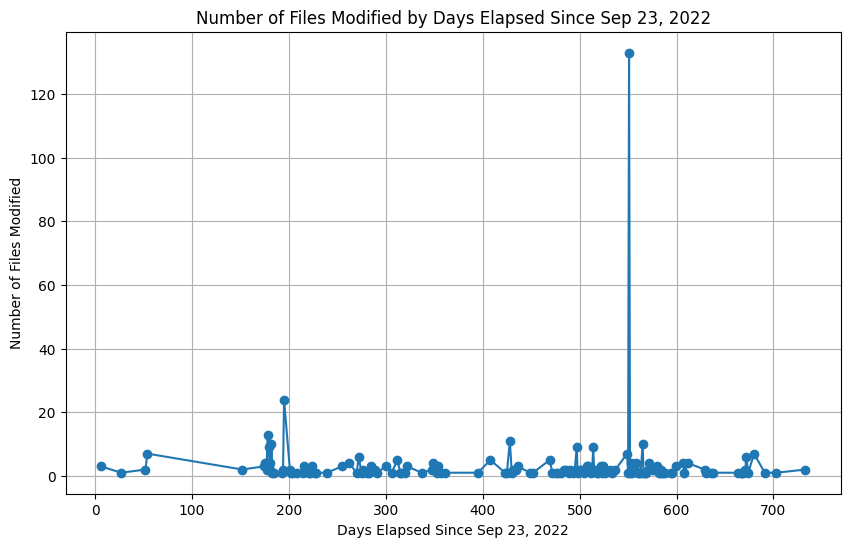

In [28]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(files_modified_by_elapsed_days.index, files_modified_by_elapsed_days.values, marker='o', linestyle='-')
plt.xlabel("Days Elapsed Since Sep 23, 2022")
plt.ylabel("Number of Files Modified")
plt.title("Number of Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)
plt.show()


### Analysis 2: Number of elapsed days since safetensors first appearead in a repo


Number of analyzed repos:  1028
Number of repos without safetensors: 612
Number of repos using safe tensors 416
(min, quartile2, median, quartile4, max) (6, 224.0, 512.5, 551.0, 733)


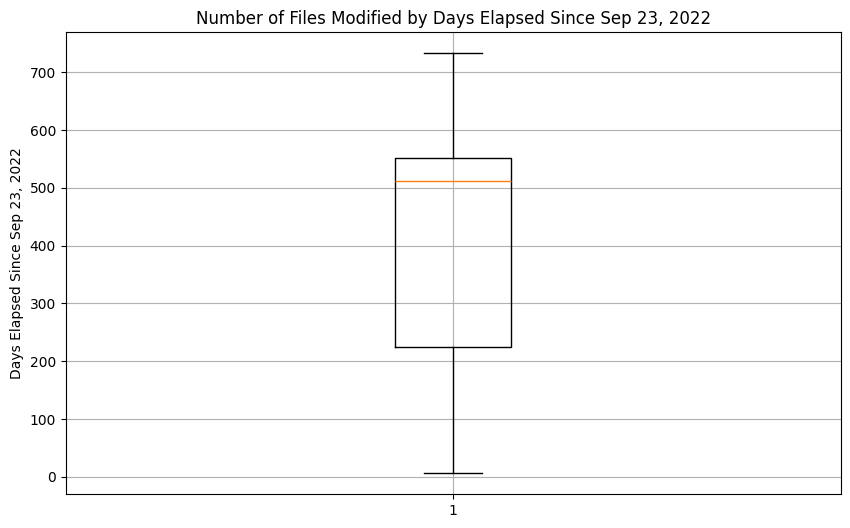

In [29]:
import matplotlib.pyplot as plt

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']


# find the lowest number of elapsed days per unique repo_url
df_safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min()
df_safetensors_first_appearance = df_safetensors_first_appearance.reset_index()


min = df_safetensors_first_appearance['elapsed_days'].min()
max = df_safetensors_first_appearance['elapsed_days'].max()
median = df_safetensors_first_appearance['elapsed_days'].median()
quartile2 = df_safetensors_first_appearance['elapsed_days'].quantile(0.25)
quartile4 = df_safetensors_first_appearance['elapsed_days'].quantile(0.75)
# count number of repos wihout safetensors
print("Number of analyzed repos: ", len(df['repo_url'].unique()))
print(f"Number of repos without safetensors: {len(df['repo_url'].unique()) - len(df_safetensors_first_appearance)}")
print("Number of repos using safe tensors", len(df_safetensors_first_appearance))
print("(min, quartile2, median, quartile4, max)",(min, quartile2, median, quartile4, max))

# show box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_safetensors_first_appearance['elapsed_days'])
plt.ylabel("Days Elapsed Since Sep 23, 2022")
plt.title("Number of Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)
plt.show()

### Analysis 3: Calendar View

#### Attempt 1

C:\Users\Matt\AppData\Local\Temp\ipykernel_19624\372967204.py:22: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



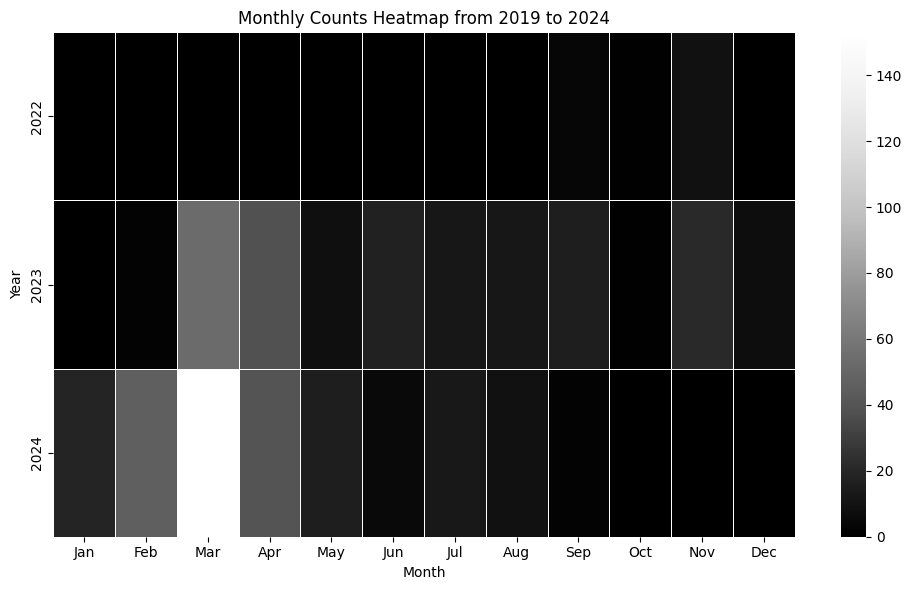

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

df_safetensors2 = df_safetensors.copy()

import pandas as pd

# Assuming 'df_safetensors2' is your existing DataFrame
# Convert the 'date' column to datetime, handling any errors
df_safetensors2["date"] = pd.to_datetime(df_safetensors2["date"], errors="coerce")

# Drop rows where 'date' could not be parsed
df_safetensors2 = df_safetensors2.dropna(subset=["date"])

# Resample to daily frequency, counting occurrences for each day
df_daily = df_safetensors2.resample("D", on="date").size().reset_index(name='count')

# Resample again to monthly frequency, summing the counts for each month
df_monthly = df_daily.resample("M", on="date").sum()

# Extract year and month from the index
df_monthly["year"] = df_monthly.index.year
df_monthly["month"] = df_monthly.index.month

# Pivot table with years as rows and months as columns
pivot_table = df_monthly.pivot_table(
    values="count",
    index="year",
    columns="month",
    aggfunc="sum"
).fillna(0)

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot size for better readability
plt.figure(figsize=(10, 6))

# Create a heatmap with Seaborn
sns.heatmap(
    pivot_table,
    cmap="Greys_r",  # Use shades of black, darker indicates higher counts
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    yticklabels=True  # Display year labels
)

# Add titles and labels
plt.title("Monthly Counts Heatmap from 2019 to 2024")
plt.xlabel("Month")
plt.ylabel("Year")

# Display the heatmap
plt.tight_layout()
plt.show()



In [45]:

df["date"] = pd.to_datetime(df["date"]) # Convert 'date' column to datetime format
df_monthly = df.resample("M", on='date').sum()  # Use 'on' parameter to specify the date column
df_monthly["year"] = df_monthly.index.year
df_monthly["month"] = df_monthly.index.month
df = files_modified_by_date.to_frame(name='count').reset_index()  # Convert Series to DataFrame and reset index
df.columns = ['date', 'count']  # Ensure the headers are 'date' and 'count'

pivot_table = df_monthly.pivot_table(
    values="count",
    index="year",
    columns="month",
    aggfunc="sum"
).fillna(0)


# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    yticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
)

plt.title("Calendar Heatmap of Library Adoption")
plt.xlabel("Month")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

DateParseError: Unknown datetime string format, unable to parse: month, at position 728

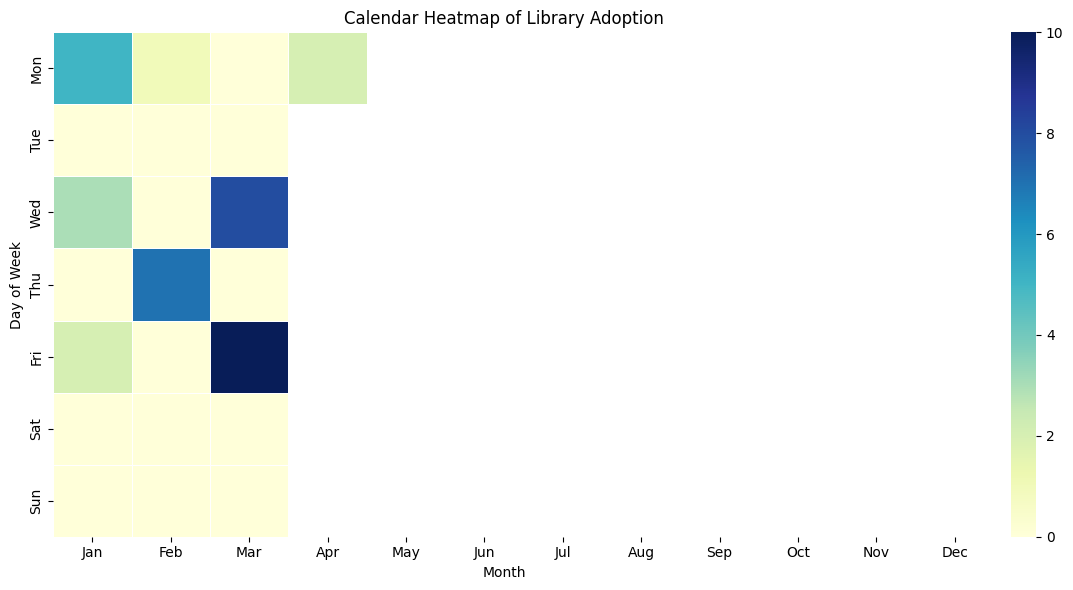

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    "date": [
        "2024-01-01", "2024-01-05", "2024-01-10",
        "2024-02-01", "2024-02-05", "2024-03-01",
        "2024-03-15", "2024-03-20", "2024-04-01",
    ],
    "adoptions": [5, 2, 3, 7, 1, 4, 6, 8, 2]
}



df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])



# df = files_modified_by_date.to_frame(name='count').reset_index()  # Convert Series to DataFrame and reset index
# df.columns = ['date', 'count']  # Ensure the headers are 'date' and 'count'

# Create a new DataFrame with the counts per day
df.set_index("date", inplace=True)
df = df.resample("D").sum().fillna(0)  # Resample to daily frequency, filling missing days with zero

# Extract month and day of the week
df["month"] = df.index.month
df["day"] = df.index.day
df["day_of_week"] = df.index.dayofweek

# Create a pivot table for the heatmap
pivot_table = df.pivot_table(
    values="adoptions",
    index="day_of_week",
    columns="month",
    aggfunc="sum"
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    yticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
)

plt.title("Calendar Heatmap of Library Adoption")
plt.xlabel("Month")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


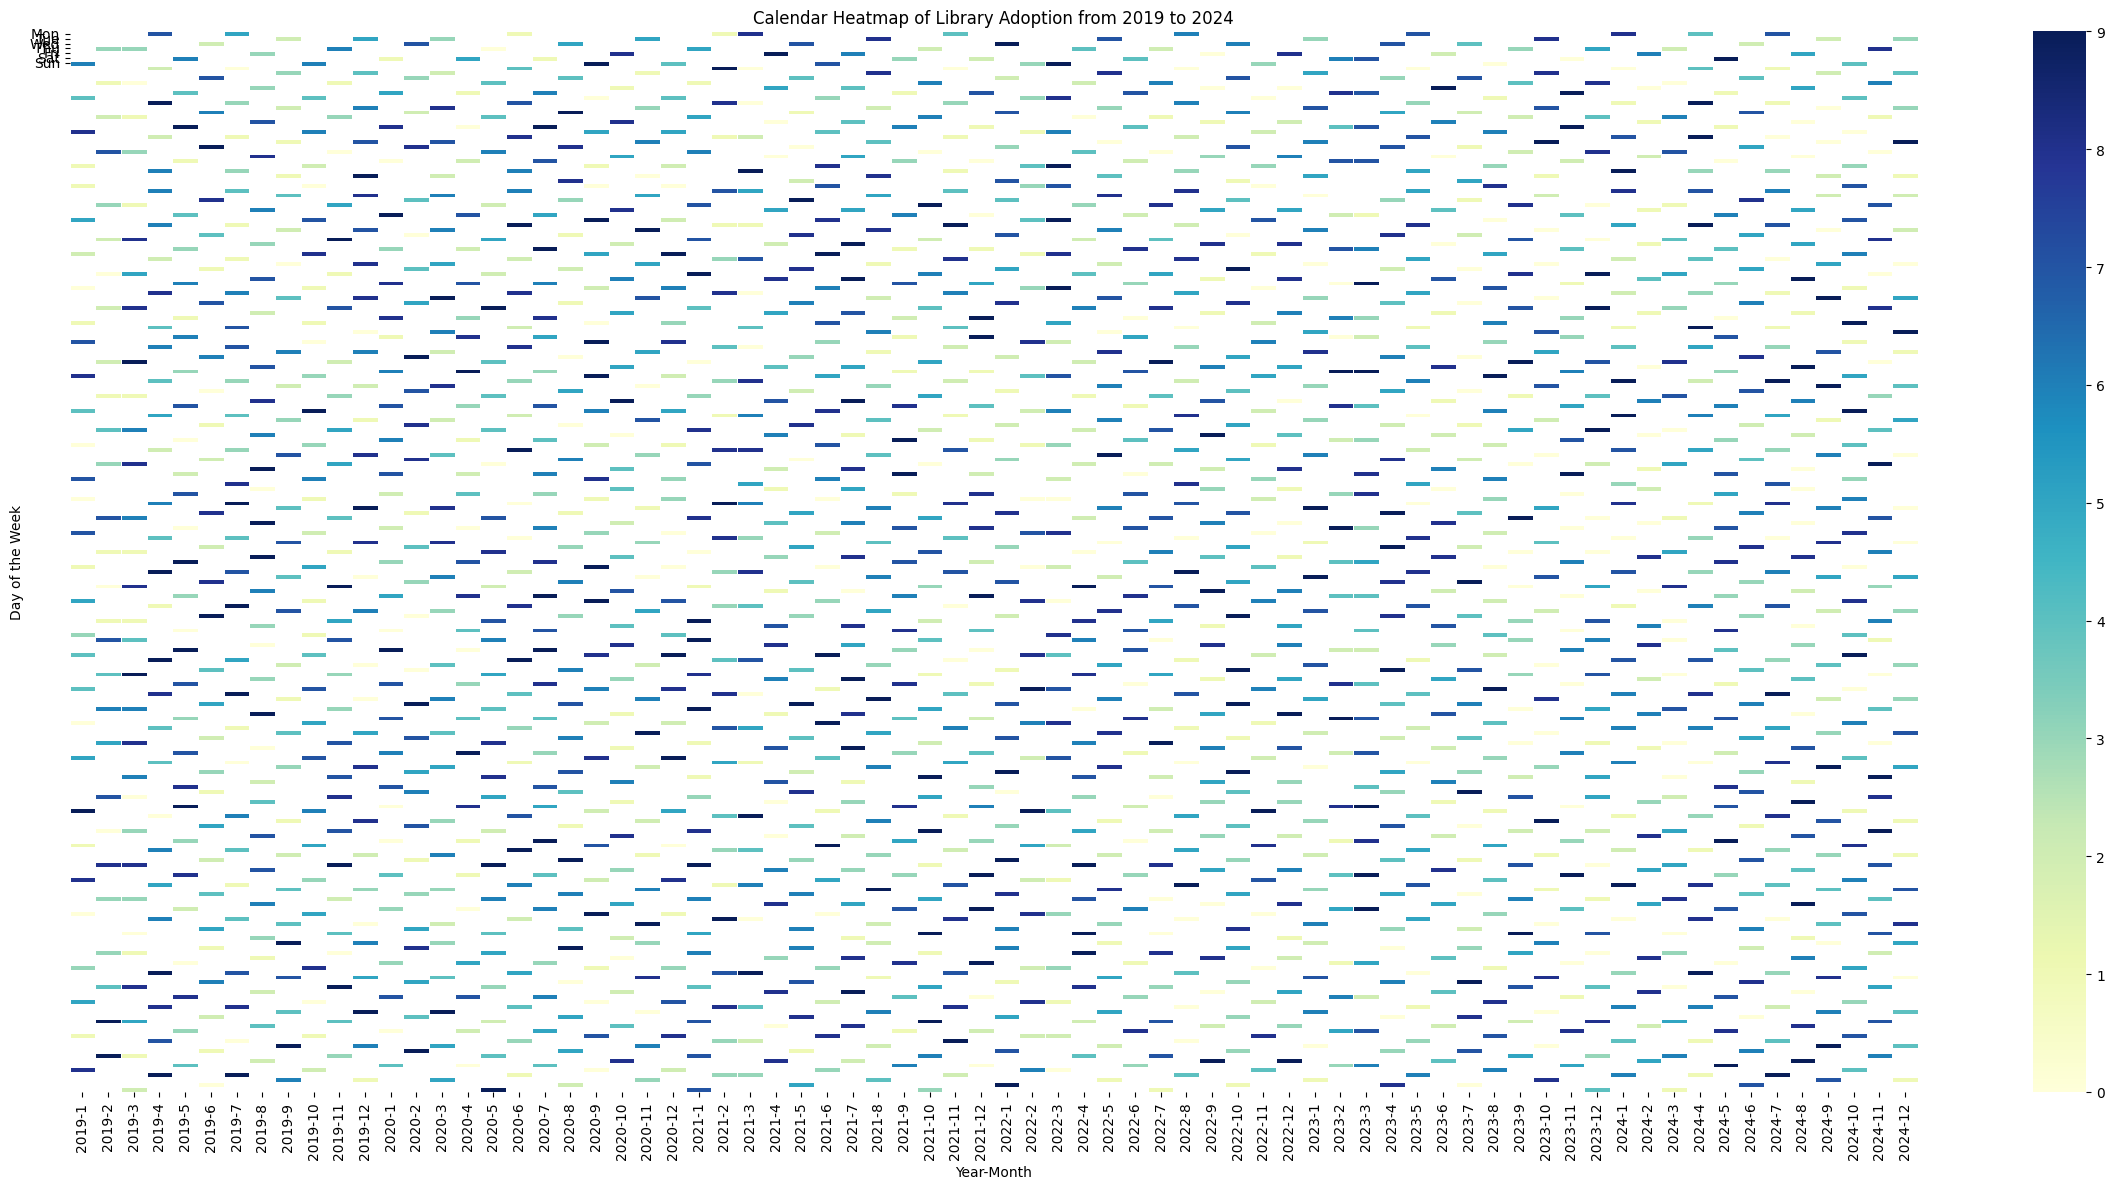

In [19]:
import pandas as pd
import numpy as np

# Create sample data
date_range = pd.date_range(start="2019-01-01", end="2024-12-31")
data = {
    "date": date_range,
    "adoptions": np.random.randint(0, 10, size=len(date_range))
}

df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])


# Set date as the index
df.set_index("date", inplace=True)
df = df.resample("D").sum().fillna(0)  # Resample to daily frequency, filling missing days with zero


df["year"] = df.index.year
df["month"] = df.index.month
df["day_of_week"] = df.index.dayofweek
df["day"] = df.index.day


# Pivot table with multi-index for year and month
pivot_table = df.pivot_table(
    values="adoptions",
    index=["day_of_week", "day"],
    columns=["year", "month"],
    aggfunc="sum"
)


import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(24, 12))  # Adjust size for better visibility
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=True,  # Shows year and month labels
    yticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
)

plt.title("Calendar Heatmap of Library Adoption from 2019 to 2024")
plt.xlabel("Year-Month")
plt.ylabel("Day of the Week")
plt.tight_layout()
plt.show()


C:\Users\Matt\AppData\Local\Temp\ipykernel_19624\1320248051.py:21: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



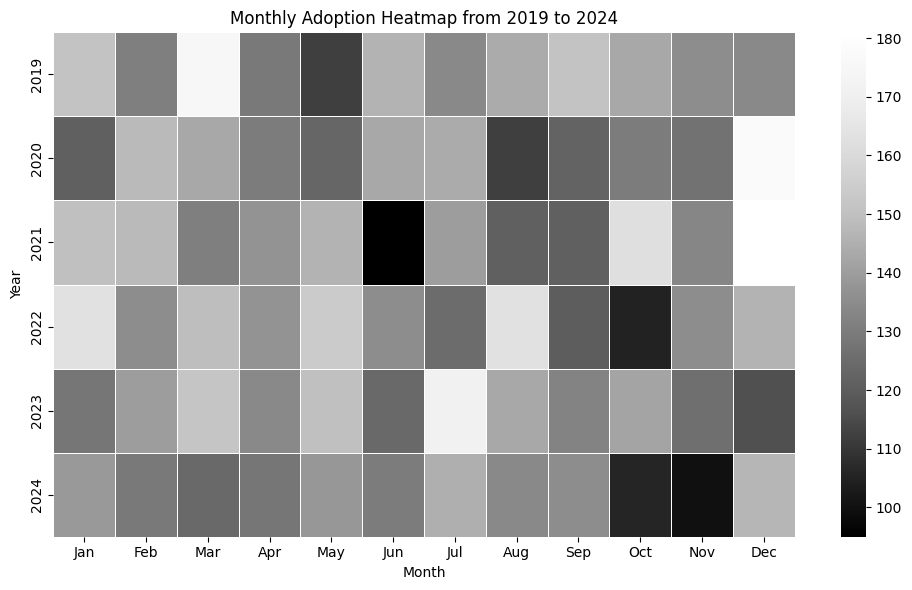

In [62]:
import pandas as pd
import numpy as np

# Create a date range from 2019-01-01 to 2024-12-31
date_range = pd.date_range(start="2019-01-01", end="2024-12-31", freq='D')
data = {
    "date": date_range,
    "adoptions": np.random.randint(0, 10, size=len(date_range))  # Replace with your adoption data
}





df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])
# Set the date as the index
df.set_index("date", inplace=True)

# Aggregate by month, summing the adoption values
df_monthly = df.resample("M").sum()  # Resample to monthly frequency
df_monthly["year"] = df_monthly.index.year
df_monthly["month"] = df_monthly.index.month
# Pivot table with years as rows and months as columns
pivot_table = df_monthly.pivot_table(
    values="adoptions",
    index="year",
    columns="month",
    aggfunc="sum"
).fillna(0)
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    # cmap="YlGnBu",
    cmap="Greys_r",
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    yticklabels=True  # Display year labels
)

plt.title("Monthly Adoption Heatmap from 2019 to 2024")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()
